# Spectral Clustering Algorithms

    Notebook version: 1.0 (Nov 11, 2016)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First complete version.  

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 1. Introduction

The key idea of spectral clustering algorithms is to search for groups of connected data. I.e, rather than pursuing compact clusters, spectral clustering allows for arbitrary shape clusters.

This can be illustrated with two artifitial datasets that we will use along this notebook.

### 1.1. Gaussian clusters:

The first one consists of 4 compact clusters generated from a Gaussian distribution. This is the kind of dataset that are best suited to centroid-based clustering algorithms like $K$-means. If the goal of the clustering algorithm is to minimize the intra-cluster distances and find a representative prototype or centroid for each cluster, $K$-means may be a good option.

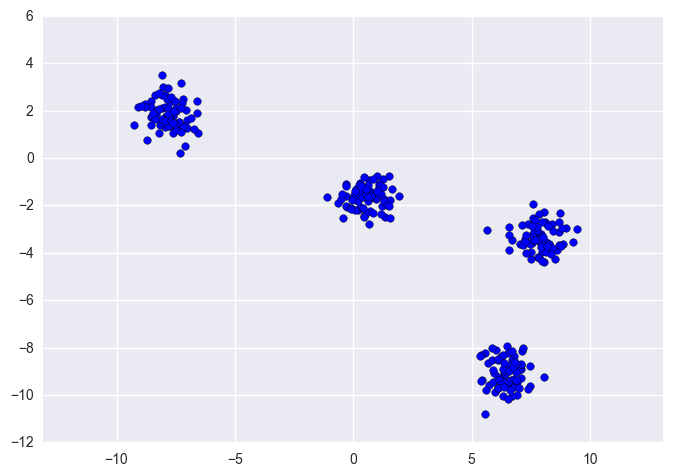

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.utils import shuffle

N = 300
nc = 4
Xs, ys = make_blobs(n_samples=N, centers=nc,
                    random_state=6, cluster_std=0.60, shuffle = False)
X, y = shuffle(Xs, ys, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30);
plt.axis('equal')
plt.show()

Note that we have computed two data matrices: 

* ${\bf X}$, which contains the data points in an arbitray ordering
* ${\bf X}_s$, where samples are ordered by clusters, according to the cluster id array, ${\bf y}$.

Note that both matrices contain the same data (rows) but in different order. The sorted matrix will be usefull later for illustration purposes, but keep in mind that, in a real clustering application, vector ${\bf y}$ is unknown (learning is not supervised), and only a data matrix with an arbitrary ordering (like ${\bf X}$) will be available. 

### 1.2. Concentric rings

The second dataset contains two concentric rings. One could expect from a clustering algorithm to identify two different clusters, one per each ring of points. If this is the case, $K$-means or any other algorithm focused on minimizing distances to some cluster centroids is not a good choice.

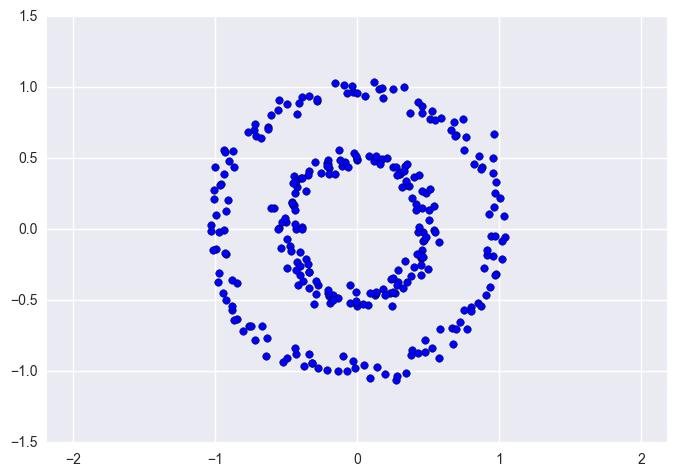

In [3]:
from sklearn.datasets.samples_generator import make_circles

X2s, y2s = make_circles(n_samples=N, factor=.5, noise=.05, shuffle=False)
X2, y2 = shuffle(X2s, y2s, random_state=0)
plt.scatter(X2[:, 0], X2[:, 1], s=30)
plt.axis('equal')
plt.show()

Note, again, that we have computed both the sorted (${\bf X}_{2s}$) and the shuffled (${\bf X}_2$) versions of the dataset in the code above.

#### Exercise 1:

Using the code of the previous notebook, run the $K$-means algorithm with 4 centroids for the two datasets. In the light of your results, why do you think $K$-means does not work well for the second dataset?

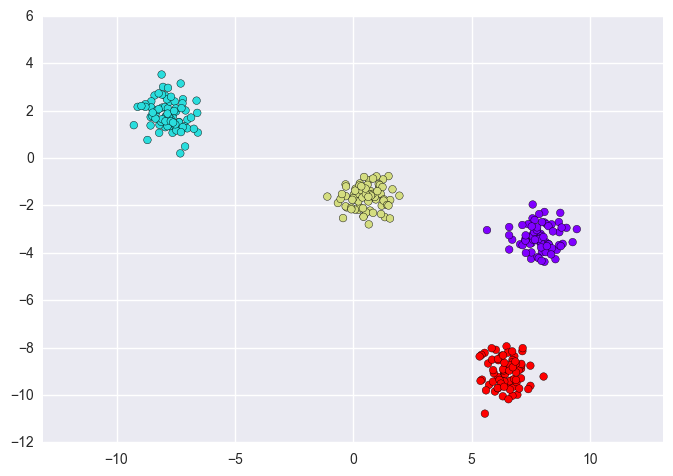

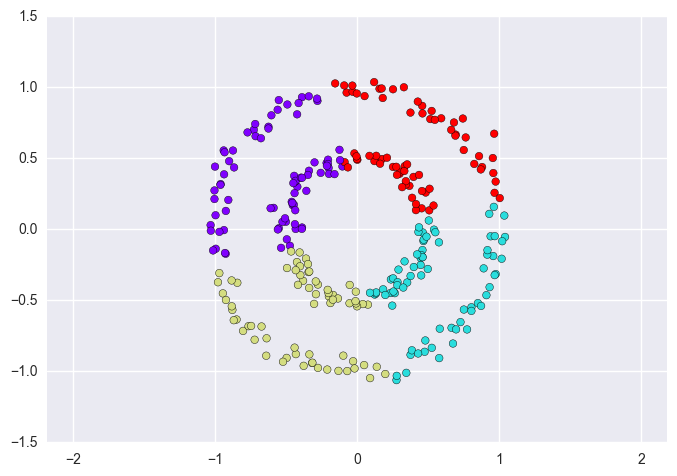

In [4]:
from sklearn.cluster import KMeans

# <SOL>
est = KMeans(n_clusters=4)
clusters = est.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=30, cmap='rainbow')
plt.axis('equal')

clusters = est.fit_predict(X2)
plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=clusters, s=30, cmap='rainbow')
plt.axis('equal')
plt.show()
# </SOL>

Spectral clustering algorithms are focused on connectivity: clusters are determined by  maximizing some measure of intra-cluster connectivity and maximizing some form of inter-cluster connectivity.

## 2. The affinity matrix

### 2.1. Similarity function

To implement a spectral clustering algorithm we must specify a similarity measure between data points. In this session, we will use the *rbf* kernel, that computes the similarity between ${\bf x}$ and ${\bf y}$ as:

$$\kappa({\bf x},{\bf y}) = \exp(-\gamma \|{\bf x}-{\bf y}\|^2)$$

Other similarity functions can be used, like the kernel functions implemented in Scikit-learn (see the <a href=http://scikit-learn.org/stable/modules/metrics.html> metrics </a> module).

### 2.2. Affinity matrix

For a dataset ${\cal S} = \{{\bf x}^{(0)},\ldots,{\bf x}^{(N-1)}\}$, the $N\times N$ **affinity matrix** ${\bf K}$ contains the similarity measure between each pair of samples. Thus, its components are

$$K_{ij} = \kappa\left({\bf x}^{(i)}, {\bf x}^{(j)}\right)$$

The following fragment of code illustrates all pairs of distances between any two points in the dataset. 

In [5]:
from sklearn.metrics.pairwise import rbf_kernel

gamma = 0.5
K = rbf_kernel(X, X, gamma=gamma)

### 2.3. Visualization

We can visualize the affinity matrix as an image, by translating component values into pixel colors or intensities.

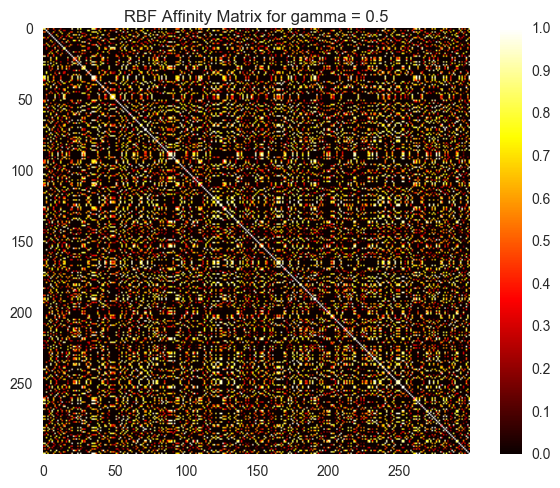

In [6]:
plt.imshow(K, cmap='hot')
plt.colorbar()
plt.title('RBF Affinity Matrix for gamma = ' + str(gamma))
plt.grid('off')
plt.show()

Despite the apparent randomness of the affinity matrix, it contains some hidden structure, that we can uncover by visualizing the affinity matrix computed with the sorted data matrix, ${\bf X}_s$.

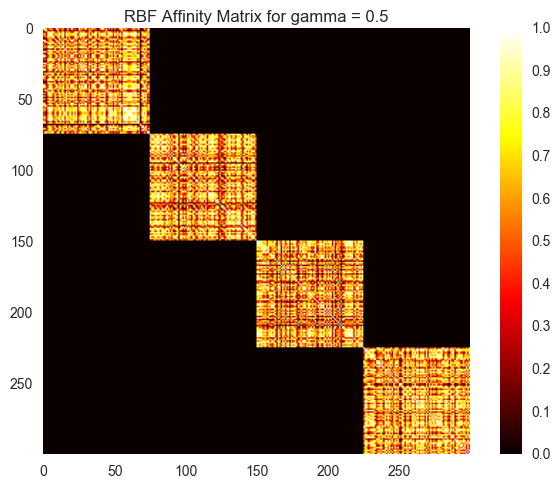

In [7]:
Ks = rbf_kernel(Xs, Xs, gamma=gamma)

plt.imshow(Ks, cmap='hot')
plt.colorbar()
plt.title('RBF Affinity Matrix for gamma = ' + str(gamma))
plt.grid('off')
plt.show()

Note that, despite their completely different appearance, both affinity matrices contain the same values, but with a different order of rows and columns.

For this dataset, the sorted affinity matrix is almost block diagonal. Note, also, that the block-wise form of this matrix depends on parameter $\gamma$.

#### Exercise 2:

Modify the selection of $\gamma$, and check the effect of this in the appearance of the *sorted* similarity matrix. Write down the values for which you consider that the structure of the matrix better resembles the number of clusters in the datasets.

Out from the diagonal block, similarities are close to zero. We can enforze a block diagonal structure be setting to zero the small similarity values. 

For instance, by thresholding ${\bf K}_s$ with threshold $t$, we get the truncated (and sorted) affinity matrix
$$
\overline{K}_{s,ij} = K_{s,ij} \cdot \text{u}(K_{s,ij} - t)
$$

(where $\text{u}()$ is the step function) which is block diagonal.

#### Exercise  3:

Compute the truncated and sorted affinity matrix with $t=0.001$

In [8]:
# <SOL>
t = 0.001
Kt = K*(K>t)    # Truncated affinity matrix
Kst = Ks*(Ks>t)  # Truncated and sorted affinity matrix
# </SOL>

## 3. Affinity matrix and data graph

Any similarity matrix defines a weighted graph in such a way that the weight of the edge linking ${\bf x}^{(i)}$ and ${\bf x}^{(j)}$ is $K_{ij}$.

If $K$ is a full matrix, the graph is fully connected (there is and edge connecting every pair of nodes). But we can get a more interesting sparse graph by setting to zero the edges with a small weights. 

For instance, let us visualize the graph for the truncated affinity matrix $\overline{\bf K}$ with threshold $t$. You can also check the effect of increasing or decreasing $t$.

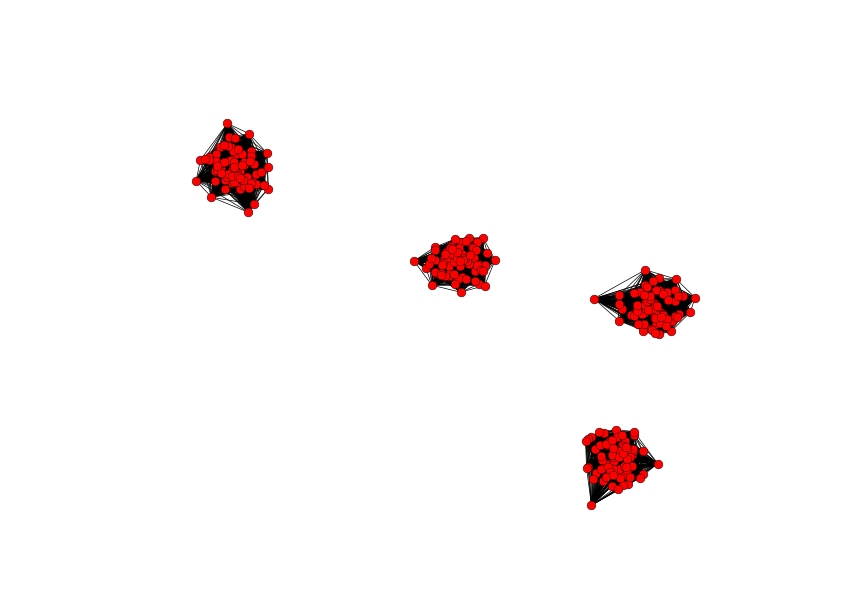

In [9]:
import networkx as nx

G = nx.from_numpy_matrix(Kt)
graphplot = nx.draw(G, X, node_size=40, width=0.5,)
plt.axis('equal')
plt.show()

Note that, for this dataset, the graph connects edges from the same cluster only. Therefore, the number of diagonal blocks in $\overline{\bf K}_s$ is equal to the number of connected components in the graph.

Note, also, the graph does not depend on the sample ordering in the data matrix: the graphs for any matrix ${\bf K}$ and its sorted version ${\bf K}_s$ are the same.

## 4. The Laplacian matrix

The <a href = https://en.wikipedia.org/wiki/Laplacian_matrix>Laplacian matrix</a> of a given affinity matrix ${\bf K}$ is given by
$${\bf L} = {\bf D} - {\bf K}$$
where ${\bf D}$ is the diagonal **degree matrix** given by
$$D_{ii}=\sum^{n}_{j} K_{ij}$$

### 4.1. Properties of the Laplacian matrix

The Laplacian matrix of any symmetric matrix ${\bf K}$ has several interesting properties:

#### P1. 

> ${\bf L}$ is symmetric and positive semidefinite. Therefore, all its eigenvalues $\lambda_0,\ldots, \lambda_{N-1}$ are non-negative. Remind that each eigenvector ${\bf v}$ with eigenvalue $\lambda$ satisfies

> $${\bf L} \cdot {\bf v} = \lambda {\bf v}$$

#### P2. 

> ${\bf L}$ has at least one eigenvector with zero eigenvalue: indeed, for ${\bf v} = {\bf 1}_N = (1, 1, \ldots, 1)^\intercal$ we get
> $${\bf L} \cdot {\bf 1}_N = {\bf 0}_N$$

> where ${\bf 0}_N$ is the $N$ dimensional all-zero vector.

#### P3. 

> If ${\bf K}$ is block diagonal, its Laplacian is block diagonal.

#### P4. 

> If ${\bf L}$ is a block diagonal with blocks ${\bf L}_0, {\bf L}_1, \ldots, {\bf L}_{c-1}$, then it has at least $c$ orthogonal eigenvectors with zero eigenvalue: indeed, each block ${\bf L}_i$ is the Laplacian matrix of the graph containing the samples in the $i$ connected component, therefore, according to property P2,

> $${\bf L}_i \cdot {\bf 1}_{N_i} = {\bf 0}_{N_i}$$

> where $N_i$ is the number of samples in the $i$-th connected component.

> Therefore, if $${\bf v}_i =  \left(\begin{array}{l} 
{\bf 0}_{N_0} \\
\vdots \\
{\bf 0}_{N_{i-1}} \\
{\bf 1}_{N_i} \\
{\bf 0}_{N_{i+1}} \\
\vdots \\
{\bf 0}_{N_{c-1}}
\end{array}
\right)
$$ 
then
> $${\bf L} \cdot {\bf v}_{i} = {\bf 0}_{N}$$

We can compute the Laplacian matrix for the given dataset and visualize the eigenvalues:

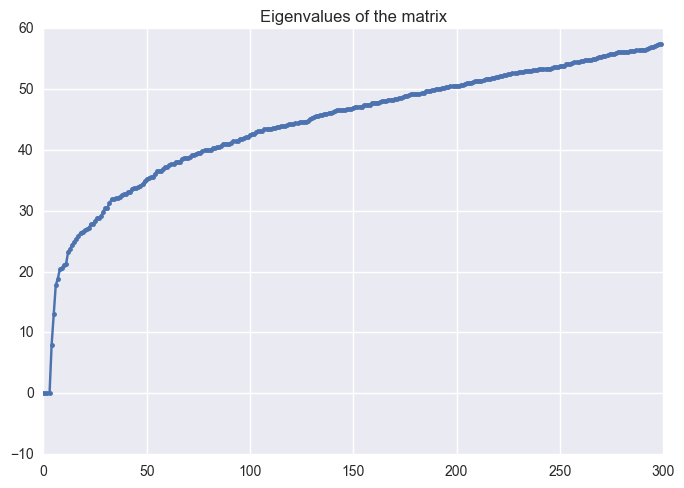

In [10]:
Dst = np.diag(np.sum(Kst, axis=1))
Lst = Dst - Kst

# Next, we compute the eigenvalues of the matrix
w = np.linalg.eigvalsh(Lst)
plt.figure()
plt.plot(w, marker='.');
plt.title('Eigenvalues of the matrix')
plt.show()

#### Exercise 4: 
Verify that ${\bf 1}_N$ is an eigenvector with zero eigenvalues. To do so, compute ${\bf L}_{st} \cdot {\bf 1}_N$ and verify that its <a href= https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html>euclidean norm</a> is close to zero (it may be not exactly zero due to finite precission errors).

Verify that vectors ${\bf v}_i$ defined above (that you can compute using `vi = (ys==i)`) also have zero eigenvalue. 

In [11]:
# <SOL>
print np.linalg.norm(Lst.dot(np.ones((N,1))))
for i in range(nc):
    vi = (ys==i)
    print np.linalg.norm(Lst.dot(vi))
# </SOL>

1.6685939227e-13
7.23361208825e-14
9.18781831926e-14
6.66548169167e-14
9.86158062359e-14


#### Exercise 5: 

Verify that the spectral properties of the Laplacian matrix computed from ${\bf K}_{st}$ still apply using the unsorted matrix, ${\bf K}_t$: compute ${\bf L}_{t} \cdot {\bf v}'_{i}$, where ${\bf v}'_i$ is a binary vector with components equal to 1 at the positions corresponding to samples in cluster $i$ (that you can compute using `vi = (y==i)`)), and verify that its euclidean norm is close to zero.

In [12]:
# <SOL>
Dt = np.diag(np.sum(Kt, axis=1))
Lt = Dt - Kt
print np.linalg.norm(Lt.dot(np.ones((N,1))))
for i in range(nc):
    vi = (y==i)
    print np.linalg.norm(Lt.dot(vi))
# </SOL>

1.42122424262e-13
7.30253361464e-14
7.9896573425e-14
6.96696573109e-14
6.0239191263e-14


Note that the position of 1's in eigenvectors ${\bf v}_i$ points out the samples in the $i$-th connected component. This suggest the following tentative clustering algorithm:

1. Compute the affinity matrix
2. Compute the laplacian matrix
3. Compute $c$ orthogonal eigenvectors with zero eigenvalue
4. If $v_{in}=1$, assign ${\bf x}^{(n)}$ to cluster $i$. 

This is the grounding idea of some spectral clustering algorithms. In this precise form, this algorithm does not usually work, for several reasons that we will discuss next, but with some modifications it becomes a powerfull method.

### 4.2. Computing eigenvectors of the Laplacian Matrix

One of the reasons why the algorithm above may not work is that vectors ${\bf v}'_0, \ldots,{\bf v}'_{c-1}$ are not the only zero eigenvectors or ${\bf L}_t$: any linear combination of them is also a zero eigenvector. Eigenvector computation algorithms may return a different set of orthogonal eigenvectors.

However, one can expect that eigenvector should have similar component in the positions corresponding to samples in the same connected component. 

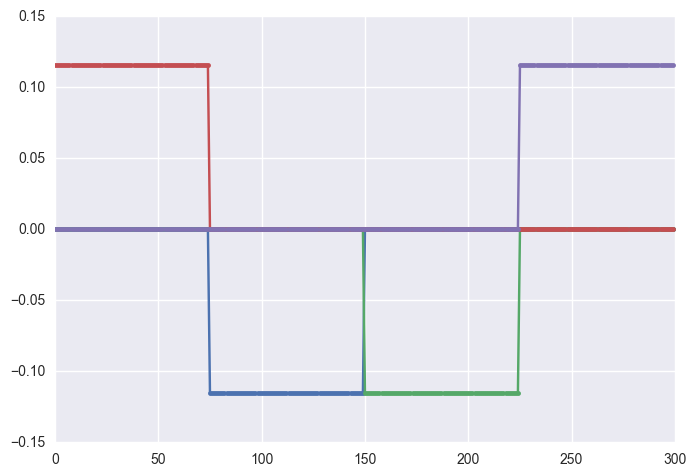

In [13]:
wst, vst = np.linalg.eigh(Lst)

for n in range(nc):
    plt.plot(vst[:,n], '.-')

### 4.3. Non block diagonal matrices.

Another reason to modify our tentative algorithm is that, in more realistic cases, the affinity matrix may have an imperfect block diagonal structure. In such cases, the smallest eigenvalues may be nonzero and eigenvectors may be not exactly piecewise constant.

#### Exercise 6

Plot the eigenvector profile for the shuffled and not thresholded affinity matrix, ${\bf K}$.

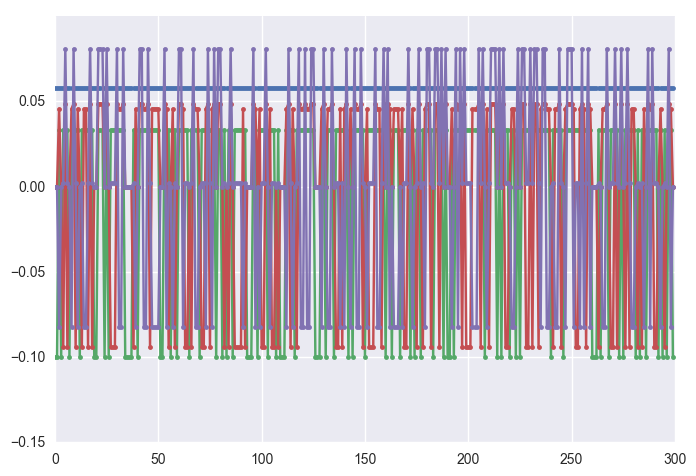

In [14]:
# <SOL>
D = np.diag(np.sum(K, axis=1))
L = D - K
w, v = np.linalg.eigh(L)
for n in range(nc):
    plt.plot(v[:,n], '.-')
# </SOL>

Note that, despite the eigenvector components can not be used as a straighforward cluster indicator, they are strongly  informative of the clustering structure. 

* All points in the same cluster have similar values of the corresponding eigenvector components $(v_{n0}, \ldots, v_{n,c-1})$.
* Points from different clusters have different values of the corresponding eigenvector components $(v_{n0}, \ldots, v_{n,c-1})$.

Therfore we can define vectors ${\bf z}^{(n)} = (v_{n0}, \ldots, v_{n,c-1})$ and apply a centroid based algorithm (like $K$-means) to identify all points with similar eigenvector components. The corresponding samples in ${\bf X}$ become the final clusters of the spectral clustering algorithm. 


One possible way to identify the cluster structure is to apply a $K-means algorithm over the eigenvector coordinates. The steps of the spectral clustering algorithm become the following

## 5. A spectral clustering (*graph cutting*) algorithm

### 5.1. The steps of the spectral clustering algorithm.

Summarizing, the steps of the spectral clustering algorithm for a data matrix ${\bf X}$ are the following:

1. Compute the affinity matrix, ${\bf K}$. Optionally, truncate the smallest components to zero.
2. Compute the laplacian matrix, ${\bf L}$
3. Compute the $c$ orthogonal eigenvectors with smallest eigenvalues, ${\bf v}_0,\ldots,{\bf v}_{c-1}$
4. Construct the sample set ${\bf Z}$ with rows ${\bf z}^{(n)} = (v_{0n}, \ldots, v_{c-1,n})$
5. Apply the $K$-means algorithms over ${\bf Z}$ with $K=c$ centroids.
6. Assign samples in ${\bf X}$ to clusters: if ${\bf z}^{(n)}$ is assigned by $K$-means to cluster $i$, assign sample ${\bf x}^{(n)}$ in ${\bf X}$ to cluster $i$.

#### Exercise 7:

In this exercise we will apply the spectral clustering algorithm to the *two-rings* dataset ${\bf X}_2$, using $\gamma = 20$, $t=0.1$ and $c = 2$ clusters.

* Complete step 1, and plot the graph induced by ${\bf K}$

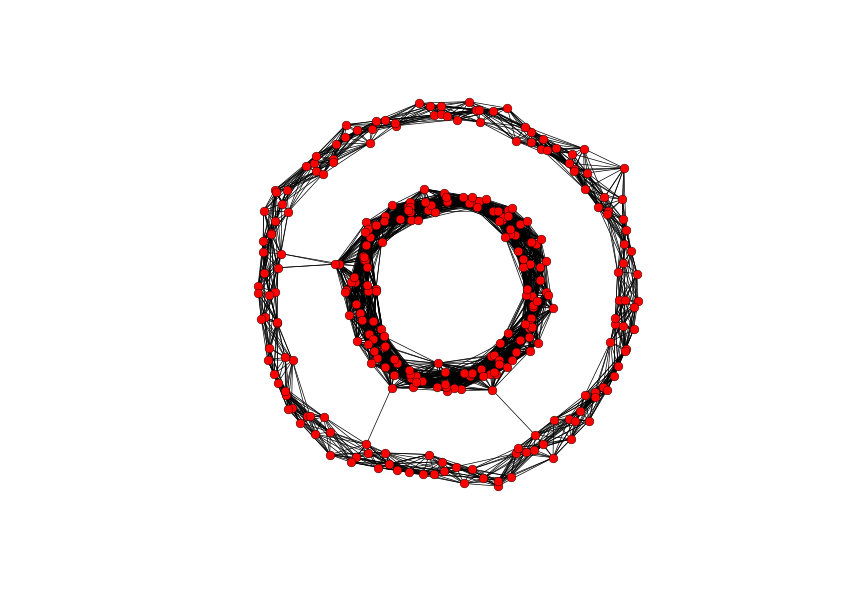

In [15]:
# <SOL>
g = 20
t = 0.1
K2 = rbf_kernel(X2, X2, gamma=g)
K2t = K2*(K2>t)
G2 = nx.from_numpy_matrix(K2t)
graphplot = nx.draw(G2, X2, node_size=40, width=0.5)
plt.axis('equal')
plt.show()
# </SOL>

* Complete step 2, 3 and 4, and draw a scatter plot of the samples in ${\bf Z}$

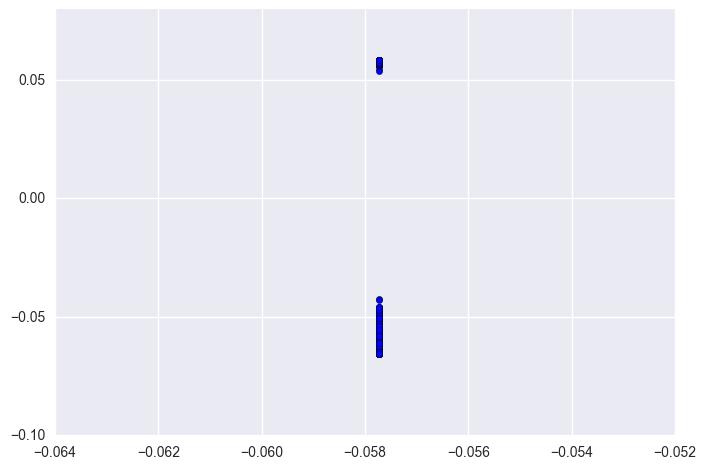

In [16]:
# <SOL>
D2t = np.diag(np.sum(K2t, axis=1))
L2t = D2t - K2t
w2t, v2t = np.linalg.eigh(L2t)
Z2t = v2t[:,0:2]

plt.scatter(Z2t[:,0], Z2t[:,1], s=20)
plt.show()
# <SOL>

* Complete step 5

In [17]:
from sklearn.cluster import KMeans
est = KMeans(n_clusters=2)
clusters = est.fit_predict(Z2t)

* Finally, complete step 6 and show, in a scatter plot, the result of the clustering algorithm

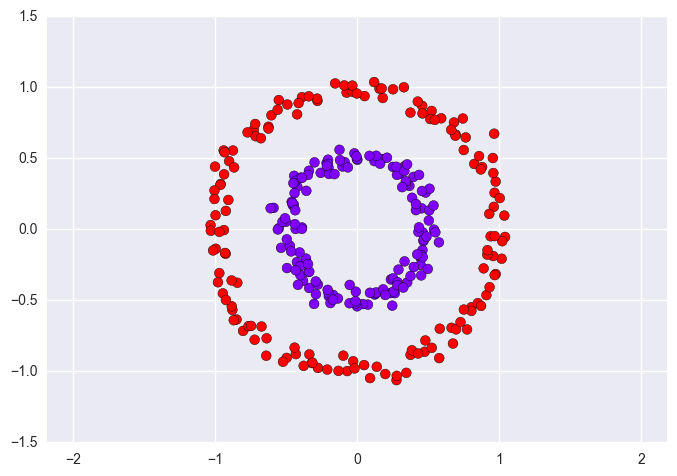

In [18]:
plt.scatter(X2[:, 0], X2[:, 1], c=clusters, s=50, cmap='rainbow')
plt.axis('equal')
plt.show()

### 5.2. Scikit-learn implementation.

The <a href=http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html> spectral clustering algorithm </a> in Scikit-learn requires the number of clusters to be specified. It works well for a small number of clusters but is not advised when using many clusters and/or data.

Finally, we are going to run spectral clustering on both datasets. Spend a few minutes figuring out the meaning of parameters of the Spectral Clustering implementation of Scikit-learn:

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

Note that there is not equivalent parameter to our threshold $t$, which has been useful for the graph representations. However, playing with $\gamma$ should be enough to get a good clustering.

The following piece of code executes the algorithm with an 'rbf' kernel. You can manually adjust the number of clusters and the parameter of the kernel to study the behavior of the algorithm. When you are done, you can also:

  - Modify the code to allow for kernels different than the 'rbf'
  - Repeat the analysis for the second dataset (*two_rings*)

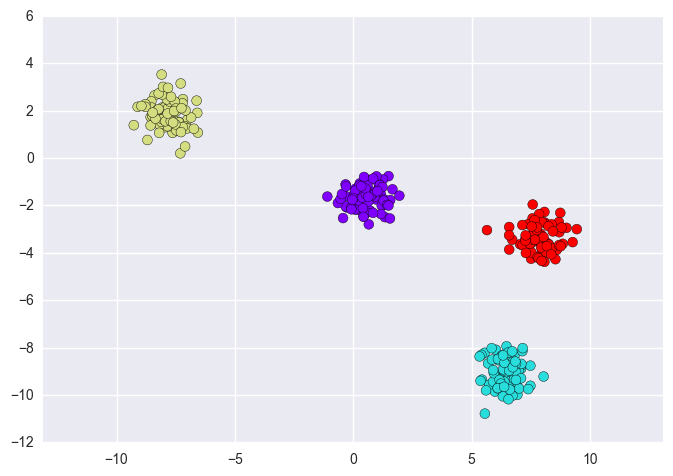

In [19]:
from sklearn.cluster import SpectralClustering

n_clusters = 4
gamma = .1  # Warning do not exceed gamma=100
SpClus = SpectralClustering(n_clusters=n_clusters,affinity='rbf',
                            gamma=gamma)
SpClus.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=SpClus.labels_.astype(np.int), s=50, 
            cmap='rainbow')
plt.axis('equal')
plt.show()

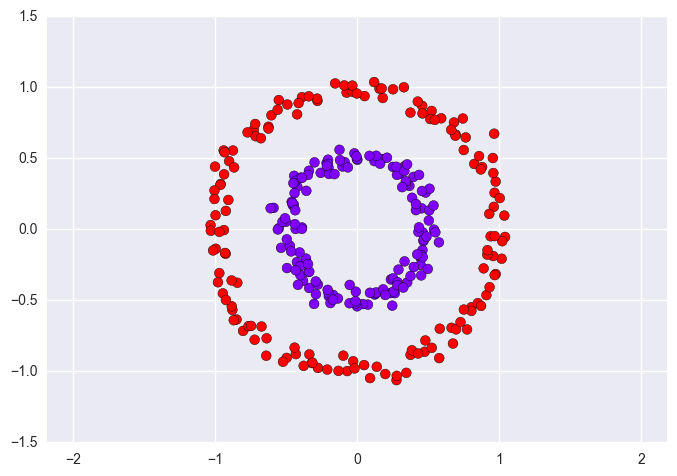

In [20]:
nc = 2
gamma = 50  #Warning do not exceed gamma=300

SpClus = SpectralClustering(n_clusters=nc, affinity='rbf', gamma=gamma)
SpClus.fit(X2)

plt.scatter(X2[:, 0], X2[:, 1], c=SpClus.labels_.astype(np.int), s=50, 
            cmap='rainbow')
plt.axis('equal')
plt.show()

/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


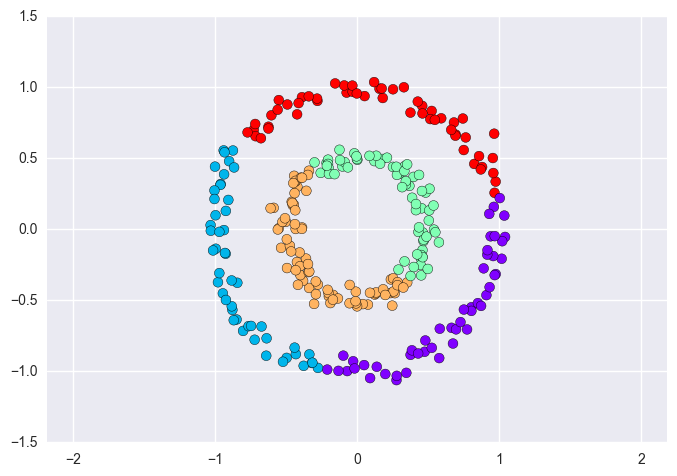

In [21]:
nc = 5
SpClus = SpectralClustering(n_clusters=nc, affinity='nearest_neighbors')
SpClus.fit(X2)

plt.scatter(X2[:, 0], X2[:, 1], c=SpClus.labels_.astype(np.int), s=50, 
            cmap='rainbow')
plt.axis('equal')
plt.show()

## 5.2. Other clustering algorithms.

### 5.2.1. Agglomerative Clustering algorithms

Bottom-up approach:

* At the beginning, each data point is a different cluster
* At each step of the algorithm two clusters are merged, according to certain performance criterion
* At the end of the algorithm, all points belong to the root node

In practice, this creates a hierarchical tree, that can be visualized with a dendogram. We can cut the tree at different levels, in each case obtaining a different number of clusters.

<img src=https://www.mathworks.com/help/stats/dendrogram_partial.png> 


#### Criteria for merging clusters

We merge the two closest clusters, where the distance between clusters is defined as:

* Single: Distance between clusters is the minimum of the distances between any two points in the clusters
* Complete: Maximal distance between any two points in each cluster
* Average: Average distance between points in both clusters
* Centroid: Distance between the (Euclidean) centroids of both clusters
* Ward: We merge centroids so that the overall increment of {\em within-cluster} variance is minimum. 

#### Python implementations

Hierarchical clustering may lead to clusters of very different sizes. Complete linkage is the worst strategy, while Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative. 

There are at least three different implementations of the algorithm:

* Scikit-learn: Only implements `complete', `ward', and `average' linkage methods. Allows for the definition of connectivity constraints
* Scipy
* fastcluster: Similar to Scipy, but more efficient with respect to computation and memory.